# 1. Import required libraries

In [1]:
%%capture
!pip install timm
!pip install randaugment

In [2]:
import os
import PIL
import time
import timm
import math
import copy
import torch
import torchvision
import itertools
import numpy as np
%matplotlib inline
import torch.nn as nn
from PIL import Image
from copy import deepcopy
import torch.optim as optim
import matplotlib.pyplot as plt
from timm.models.layers.activations import *
from collections import OrderedDict
from torchvision import transforms, models, datasets
from torch.utils.data.sampler import SubsetRandomSampler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from timm.loss import LabelSmoothingCrossEntropy
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from randaugment import RandAugment, ImageNetPolicy, Cutout
from tqdm import tqdm

# 2. Data Preparation

In [3]:
# Hyperparameters
batch_size = 32
num_epochs = 50

In [4]:
root_dir = '/kaggle/input/chest-xray-classification'
data_transforms = {
    'train':transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        Cutout(size=16),
        RandAugment(),
        ImageNetPolicy(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}

In [5]:
image_datasets = {x : datasets.ImageFolder(os.path.join(root_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
data_loader = {x : torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size if x!='test' else 2, shuffle=True, num_workers=2, pin_memory=True) for x in ['train', 'val', 'test']}
dataset_sizes = {x : len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

In [6]:
print(dataset_sizes)
print(class_names)

{'train': 17813, 'val': 2227, 'test': 2229}
['COVID', 'Lung_Opacity', 'Normal', 'Pneunomia', 'Tuberculosis']


# 3. Model

In [7]:
model = timm.create_model('efficientnet_b2', pretrained=True)
model.classifier

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b2_ra-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_ra-bcdf34b7.pth


Linear(in_features=1408, out_features=1000, bias=True)

In [8]:
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1408, 512)),
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(512, 256)),
    ('relu2', nn.ReLU()),
    ('fc3', nn.Linear(256, 5))
]))
model.classifier = classifier
model = model.to(device)

for params in model.parameters():
    params.requires_grad = True
    
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_params(model))

8555015


# 4. Training

In [9]:
criterion = LabelSmoothingCrossEntropy()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs , path='model.pth'):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = math.inf
    best_acc = 0.
    
    for epoch in range(num_epochs):
        since_e = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_correct = 0
            
            for i, (inputs, labels) in tqdm(enumerate(data_loader[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                if i%1000==999:
                    print(f"[{epoch+1}, {i} loss: {running_loss/(i*inputs.size(0)):.4f}]")
                
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item()*inputs.size(0)
                running_correct += torch.sum(preds==labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_correct / dataset_sizes[phase]
            print('{} loss: {:.4f} acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val':
                scheduler.step(epoch_acc)
            if phase == 'val' and epoch_acc > best_acc:
                print(f'New acc: {epoch_acc:.4f}, previous acc: {best_acc:.4f}')
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), path)
        time_e = time.time() - since_e
        print(f'Training epoch {epoch+1} complete in: {time_e//60:.0f}m {time_e%60:.0f}s')
    time_elapsed = time.time()-since
    print('Training complete in: {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best val acc: {:.4f} Best val loss: {:.4f}'.format(best_acc, best_loss))
    
    model.load_state_dict(best_model_wts)
    return model

In [11]:
model = train_model(model, criterion, optimizer, scheduler)

Epoch 1/50


557it [05:53,  1.57it/s]

train loss: 1.0474 acc: 0.6551



70it [00:27,  2.55it/s]


val loss: 0.6713 acc: 0.8666
New acc: 0.8666, previous acc: 0.0000
Training epoch 1 complete in: 6m 22s
Epoch 2/50


557it [05:14,  1.77it/s]

train loss: 0.8047 acc: 0.7884



70it [00:23,  2.95it/s]


val loss: 0.6088 acc: 0.9021
New acc: 0.9021, previous acc: 0.8666
Training epoch 2 complete in: 5m 39s
Epoch 3/50


557it [05:18,  1.75it/s]

train loss: 0.7477 acc: 0.8186



70it [00:22,  3.06it/s]


val loss: 0.5743 acc: 0.9187
New acc: 0.9187, previous acc: 0.9021
Training epoch 3 complete in: 5m 42s
Epoch 4/50


557it [05:19,  1.74it/s]

train loss: 0.7097 acc: 0.8376



70it [00:22,  3.05it/s]


val loss: 0.5732 acc: 0.9192
New acc: 0.9192, previous acc: 0.9187
Training epoch 4 complete in: 5m 43s
Epoch 5/50


557it [05:19,  1.74it/s]

train loss: 0.6938 acc: 0.8480



70it [00:23,  2.99it/s]

val loss: 0.5794 acc: 0.9160
Training epoch 5 complete in: 5m 43s
Epoch 6/50



557it [05:19,  1.74it/s]

train loss: 0.6697 acc: 0.8600



70it [00:22,  3.09it/s]

val loss: 0.5587 acc: 0.9160
Training epoch 6 complete in: 5m 43s
Epoch 7/50



557it [05:23,  1.72it/s]

train loss: 0.6620 acc: 0.8608



70it [00:23,  2.92it/s]


val loss: 0.5417 acc: 0.9282
New acc: 0.9282, previous acc: 0.9192
Training epoch 7 complete in: 5m 48s
Epoch 8/50


557it [05:24,  1.72it/s]

train loss: 0.6527 acc: 0.8668



70it [00:24,  2.87it/s]


val loss: 0.5355 acc: 0.9340
New acc: 0.9340, previous acc: 0.9282
Training epoch 8 complete in: 5m 49s
Epoch 9/50


557it [05:27,  1.70it/s]

train loss: 0.6465 acc: 0.8719



70it [00:24,  2.82it/s]


val loss: 0.5390 acc: 0.9344
New acc: 0.9344, previous acc: 0.9340
Training epoch 9 complete in: 5m 53s
Epoch 10/50


557it [05:27,  1.70it/s]

train loss: 0.6378 acc: 0.8773



70it [00:22,  3.15it/s]

val loss: 0.5568 acc: 0.9237
Training epoch 10 complete in: 5m 50s
Epoch 11/50



557it [05:30,  1.69it/s]

train loss: 0.6268 acc: 0.8826



70it [00:25,  2.77it/s]


val loss: 0.5315 acc: 0.9371
New acc: 0.9371, previous acc: 0.9344
Training epoch 11 complete in: 5m 56s
Epoch 12/50


557it [05:32,  1.68it/s]

train loss: 0.6242 acc: 0.8824



70it [00:23,  2.92it/s]


val loss: 0.5116 acc: 0.9425
New acc: 0.9425, previous acc: 0.9371
Training epoch 12 complete in: 5m 57s
Epoch 13/50


557it [05:26,  1.71it/s]

train loss: 0.6209 acc: 0.8827



70it [00:23,  2.98it/s]

val loss: 0.5172 acc: 0.9385
Training epoch 13 complete in: 5m 50s
Epoch 14/50



557it [05:23,  1.72it/s]

train loss: 0.6175 acc: 0.8844



70it [00:23,  3.01it/s]

val loss: 0.5387 acc: 0.9291
Training epoch 14 complete in: 5m 47s
Epoch 15/50



557it [05:26,  1.71it/s]

train loss: 0.6129 acc: 0.8871



70it [00:24,  2.92it/s]

val loss: 0.5200 acc: 0.9389
Training epoch 15 complete in: 5m 50s
Epoch 16/50



557it [05:28,  1.69it/s]


train loss: 0.6068 acc: 0.8892


70it [00:26,  2.66it/s]

val loss: 0.5216 acc: 0.9394
Training epoch 16 complete in: 5m 55s
Epoch 17/50



557it [05:31,  1.68it/s]

train loss: 0.5809 acc: 0.9034



70it [00:26,  2.69it/s]


val loss: 0.5075 acc: 0.9452
New acc: 0.9452, previous acc: 0.9425
Training epoch 17 complete in: 5m 58s
Epoch 18/50


557it [05:24,  1.72it/s]

train loss: 0.5716 acc: 0.9068



70it [00:27,  2.59it/s]


val loss: 0.5063 acc: 0.9457
New acc: 0.9457, previous acc: 0.9452
Training epoch 18 complete in: 5m 52s
Epoch 19/50


557it [05:29,  1.69it/s]

train loss: 0.5695 acc: 0.9092



70it [00:26,  2.64it/s]


val loss: 0.5003 acc: 0.9484
New acc: 0.9484, previous acc: 0.9457
Training epoch 19 complete in: 5m 56s
Epoch 20/50


557it [05:24,  1.72it/s]

train loss: 0.5674 acc: 0.9108



70it [00:26,  2.60it/s]

val loss: 0.5044 acc: 0.9470
Training epoch 20 complete in: 5m 51s
Epoch 21/50



557it [05:29,  1.69it/s]

train loss: 0.5590 acc: 0.9146



70it [00:25,  2.74it/s]

val loss: 0.5030 acc: 0.9470
Training epoch 21 complete in: 5m 55s
Epoch 22/50



557it [05:30,  1.69it/s]

train loss: 0.5647 acc: 0.9128



70it [00:23,  3.03it/s]

val loss: 0.4993 acc: 0.9484
Training epoch 22 complete in: 5m 54s
Epoch 23/50



557it [05:32,  1.68it/s]

train loss: 0.5623 acc: 0.9120



70it [00:22,  3.13it/s]

val loss: 0.4996 acc: 0.9479
Training epoch 23 complete in: 5m 55s
Epoch 24/50



557it [05:22,  1.73it/s]

train loss: 0.5578 acc: 0.9145



70it [00:27,  2.55it/s]


val loss: 0.4978 acc: 0.9497
New acc: 0.9497, previous acc: 0.9484
Training epoch 24 complete in: 5m 50s
Epoch 25/50


557it [05:20,  1.74it/s]

train loss: 0.5547 acc: 0.9151



70it [00:22,  3.16it/s]

val loss: 0.4975 acc: 0.9497
Training epoch 25 complete in: 5m 42s
Epoch 26/50



557it [05:26,  1.70it/s]

train loss: 0.5582 acc: 0.9156



70it [00:23,  2.93it/s]

val loss: 0.4961 acc: 0.9497
Training epoch 26 complete in: 5m 51s
Epoch 27/50



557it [05:20,  1.74it/s]

train loss: 0.5608 acc: 0.9128



70it [00:22,  3.09it/s]


val loss: 0.4973 acc: 0.9511
New acc: 0.9511, previous acc: 0.9497
Training epoch 27 complete in: 5m 44s
Epoch 28/50


557it [05:34,  1.66it/s]

train loss: 0.5531 acc: 0.9156



70it [00:22,  3.06it/s]

val loss: 0.4993 acc: 0.9470
Training epoch 28 complete in: 5m 58s
Epoch 29/50



557it [05:30,  1.69it/s]

train loss: 0.5547 acc: 0.9173



70it [00:23,  3.01it/s]

val loss: 0.5001 acc: 0.9502
Training epoch 29 complete in: 5m 54s
Epoch 30/50



557it [05:31,  1.68it/s]

train loss: 0.5562 acc: 0.9174



70it [00:23,  2.98it/s]

val loss: 0.5001 acc: 0.9470
Training epoch 30 complete in: 5m 55s
Epoch 31/50



557it [05:29,  1.69it/s]

train loss: 0.5558 acc: 0.9180



70it [00:28,  2.42it/s]

val loss: 0.4978 acc: 0.9488
Training epoch 31 complete in: 5m 58s
Epoch 32/50



557it [05:26,  1.71it/s]

train loss: 0.5529 acc: 0.9184



70it [00:22,  3.05it/s]


val loss: 0.4983 acc: 0.9533
New acc: 0.9533, previous acc: 0.9511
Training epoch 32 complete in: 5m 50s
Epoch 33/50


557it [05:35,  1.66it/s]

train loss: 0.5518 acc: 0.9167



70it [00:24,  2.84it/s]

val loss: 0.4991 acc: 0.9461
Training epoch 33 complete in: 5m 60s
Epoch 34/50



557it [05:26,  1.70it/s]

train loss: 0.5582 acc: 0.9162



70it [00:23,  3.00it/s]

val loss: 0.4974 acc: 0.9511
Training epoch 34 complete in: 5m 50s
Epoch 35/50



557it [05:34,  1.66it/s]

train loss: 0.5549 acc: 0.9170



70it [00:22,  3.11it/s]

val loss: 0.4981 acc: 0.9479
Training epoch 35 complete in: 5m 57s
Epoch 36/50



557it [05:29,  1.69it/s]

train loss: 0.5506 acc: 0.9208



70it [00:23,  2.93it/s]

val loss: 0.4998 acc: 0.9506
Training epoch 36 complete in: 5m 54s
Epoch 37/50



557it [05:35,  1.66it/s]

train loss: 0.5572 acc: 0.9147



70it [00:23,  3.01it/s]

val loss: 0.5002 acc: 0.9493
Training epoch 37 complete in: 5m 59s
Epoch 38/50



557it [05:29,  1.69it/s]

train loss: 0.5557 acc: 0.9164



70it [00:22,  3.05it/s]

val loss: 0.4978 acc: 0.9493
Training epoch 38 complete in: 5m 53s
Epoch 39/50



557it [05:35,  1.66it/s]

train loss: 0.5555 acc: 0.9172



70it [00:22,  3.08it/s]

val loss: 0.4987 acc: 0.9488
Training epoch 39 complete in: 5m 59s
Epoch 40/50



557it [05:28,  1.69it/s]

train loss: 0.5542 acc: 0.9158



70it [00:23,  3.00it/s]

val loss: 0.4992 acc: 0.9493
Training epoch 40 complete in: 5m 52s
Epoch 41/50



557it [05:36,  1.66it/s]

train loss: 0.5530 acc: 0.9169



70it [00:23,  2.98it/s]

val loss: 0.5002 acc: 0.9506
Training epoch 41 complete in: 6m 0s
Epoch 42/50



557it [05:26,  1.70it/s]

train loss: 0.5544 acc: 0.9170



70it [00:22,  3.06it/s]

val loss: 0.4975 acc: 0.9497
Training epoch 42 complete in: 5m 50s
Epoch 43/50



557it [05:31,  1.68it/s]

train loss: 0.5488 acc: 0.9213



70it [00:30,  2.27it/s]

val loss: 0.4967 acc: 0.9502
Training epoch 43 complete in: 6m 2s
Epoch 44/50



557it [05:27,  1.70it/s]

train loss: 0.5538 acc: 0.9175



70it [00:22,  3.16it/s]

val loss: 0.4975 acc: 0.9484
Training epoch 44 complete in: 5m 50s
Epoch 45/50



557it [05:24,  1.72it/s]

train loss: 0.5535 acc: 0.9183



70it [00:22,  3.12it/s]

val loss: 0.4975 acc: 0.9497
Training epoch 45 complete in: 5m 47s
Epoch 46/50



557it [05:37,  1.65it/s]

train loss: 0.5588 acc: 0.9144



70it [00:23,  3.02it/s]

val loss: 0.4987 acc: 0.9511
Training epoch 46 complete in: 6m 0s
Epoch 47/50



557it [05:32,  1.67it/s]

train loss: 0.5560 acc: 0.9164



70it [00:22,  3.09it/s]

val loss: 0.4971 acc: 0.9502
Training epoch 47 complete in: 5m 56s
Epoch 48/50



557it [05:32,  1.67it/s]

train loss: 0.5518 acc: 0.9173



70it [00:28,  2.48it/s]

val loss: 0.4985 acc: 0.9502
Training epoch 48 complete in: 6m 1s
Epoch 49/50



557it [05:15,  1.77it/s]

train loss: 0.5531 acc: 0.9177



70it [00:22,  3.14it/s]

val loss: 0.4971 acc: 0.9511
Training epoch 49 complete in: 5m 38s
Epoch 50/50



557it [05:22,  1.73it/s]

train loss: 0.5581 acc: 0.9147



70it [00:27,  2.55it/s]


val loss: 0.4982 acc: 0.9511
Training epoch 50 complete in: 5m 50s
Training complete in: 293m 47s
Best val acc: 0.9533 Best val loss: 0.4983


# 5. Prediction on Test set

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
# model = timm.create_model('efficientnet_b0', pretrained=True)
# classifier = nn.Sequential(OrderedDict([
#     ('fc1', nn.Linear(1408, 512)),
#     ('relu1', nn.ReLU()),
#     ('fc2', nn.Linear(512, 256)),
#     ('relu2', nn.ReLU()),
#     ('fc3', nn.Linear(256, 5))
# ]))
# model.classifier = classifier
# model = model.to(device)

model.load_state_dict(torch.load('./model.pth'))

<All keys matched successfully>

Testing complete in 0m 56s
              precision    recall  f1-score   support

           0    0.99118   0.93094   0.96011       362
           1    0.95726   0.93023   0.94356       602
           2    0.93563   0.97358   0.95423      1060
           3    0.98425   0.92593   0.95420       135
           4    0.90541   0.95714   0.93056        70

    accuracy                        0.95155      2229
   macro avg    0.95475   0.94357   0.94853      2229
weighted avg    0.95249   0.95155   0.95156      2229



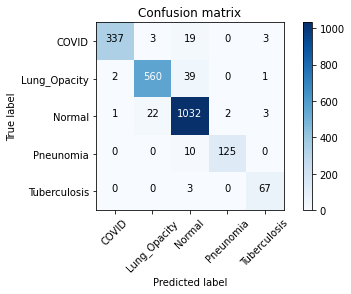

In [14]:
since = time.time()
model.eval()
y_test = []
y_pred = []
y_pred_proba = []
for images, labels in data_loader['test']:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())
    y_pred_proba.append(outputs.data.cpu().numpy())
    
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)
y_pred_proba = np.concatenate(y_pred_proba)
time_elapsed = time.time() - since

print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

confusion_mtx = confusion_matrix(y_test, y_pred)
# plot the confusion matrix
plot_labels = ['COVID', 'Lung_Opacity', 'Normal', 'Pneunomia', 'Tuberculosis']

plot_confusion_matrix(confusion_mtx, plot_labels)
report = classification_report(y_test, y_pred, digits=5)
print(report)

In [15]:
def softmax(vec):
    exponential = np.exp(vec)
    probabilities = exponential / np.sum(exponential)
    return probabilities

y_pred_proba = np.array([list(softmax(i)) for i in y_pred_proba])

ROC curve (area = 0.9956)


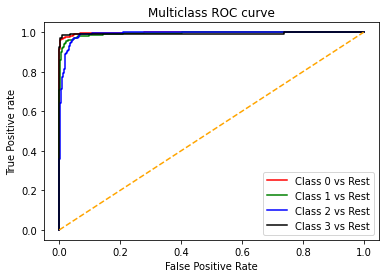

In [16]:
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo')
print('ROC curve (area = %0.4f)' % roc_auc)
fpr = {}
tpr = {}
thresh ={}
for i in range(5):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)

# plotting    
plt.plot(fpr[0], tpr[0], color='red', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], color='black', label='Class 3 vs Rest')
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 